# Place field estimation for CRCNS hc-3 data; synthetic data generation, replay (SWR) detection and scoring

_Etienne Ackermann, 12/16/2015_

The data can be downloaded from the [CRCNS](http://crcns.org/data-sets/hc/hc-3) (Collaborative Research in Computational Neuroscience) website, and the ```hc-3``` data set in particular.

### Summary

Here I will do a very quick and rough place field visualization to see which cells show place preferences. In particular, we limit the spikes to only those where the animal was running at some minimum velocity (3 cm/s), and then we further restrict place cells to be those with some minimum maximum firing rate (2 Hz) and a maximum mean firing rate (4 Hz).


**WARNING:** We do not know what the sampling frequency is that's associated with the .whl trajectory file. We can assume that the entire experiment was logged in the .whl file, and that a uniform sampling interval was used, so that we can determine the sampling frequency by taking the number of samples in the .whl file, and dividing by the experiment duration. We should check to see that several of the .whl-experiment pairs give us the same sampling frequency...

**CONCLUSION:** It seems like the .whl files were logged at 60 Hz, which is a common sampling rate for video cameras, so at least it seems plausible.

---

**Plan:** to do replay detection, I need to import SWR detection code from other hc-3 notebooks; in addition, the decoding will happen in a 5:20 ms fashion, with additional minimum and maximum sequence length cut-offs. After detection, we then do the correlation analysis, and simultaneously compute replay score with trained model. For this to be directly comparable, it might make most sense to apply the same length restrictions as on the correlation-associated sequences, and also to do the HMM decoding using scaled 5 ms bins...

## Load trajectory data from .whl file

Cannot load files in C:/...; trying Unix location instead.
Data loaded successfully.


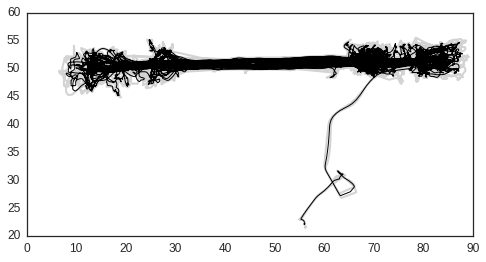

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from pandas import Series, DataFrame

%matplotlib inline

# read trajectory:
try:
    df1whl = pd.read_table( 'C://Etienne//Dropbox//neoReader//Data//gor01-6-7//2006-6-7_11-26-53_lin1//2006-6-7_11-26-53.whl',sep='\t', skiprows=0, names=['x1', 'y1', 'x2', 'y2'] )
    df2whl = pd.read_table( 'C://Etienne//Dropbox//neoReader//Data//gor01-6-7//2006-6-7_16-40-19_lin2//2006-6-7_16-40-19.whl',sep='\t', skiprows=0, names=['x1', 'y1', 'x2', 'y2'] )
except:
    print( "Cannot load files in C:/...; trying Unix location instead.")
    try:
        #df1whl = pd.read_table( '/home/etienne/Dropbox/neoReader/Data/gor01-6-7/2006-6-7_11-26-53_lin1/2006-6-7_11-26-53.whl',sep='\t', skiprows=0, names=['x1', 'y1', 'x2', 'y2'] )
        df2whl = pd.read_table( '/home/etienne/Dropbox/neoReader/Data/gor01-6-7/2006-6-7_16-40-19_lin2/2006-6-7_16-40-19.whl',sep='\t', skiprows=0, names=['x1', 'y1', 'x2', 'y2'] )
        #df1whl = pd.read_table( '/home/etienne/Dropbox/neoReader/Data/gor01-6-12/2006-6-12_15-55-31_lin1/2006-6-12_15-55-31.whl',sep='\t', skiprows=0, names=['x1', 'y1', 'x2', 'y2'] )
        #df2whl = pd.read_table( '/home/etienne/Dropbox/neoReader/Data/gor01-6-12/2006-6-12_16-53-46_lin2/2006-6-12_16-53-46.whl',sep='\t', skiprows=0, names=['x1', 'y1', 'x2', 'y2'] )       
        #df1whl = pd.read_table( '/home/etienne/Dropbox/neoReader/Data/gor01-6-13/2006-6-13_14-42-6_lin1/2006-6-13_14-42-6.whl',sep='\t', skiprows=0, names=['x1', 'y1', 'x2', 'y2'] )
        #df2whl = pd.read_table( '/home/etienne/Dropbox/neoReader/Data/gor01-6-13/2006-6-13_15-22-3_lin2/2006-6-13_15-22-3.whl',sep='\t', skiprows=0, names=['x1', 'y1', 'x2', 'y2'] )
    except:
        print( "Cannot load files in Unix location; trying Mac location instead.")
        try:
            
            #df1whl = pd.read_table( '/Users/etienne/Dropbox/neoReader/Data/gor01-6-7/2006-6-7_11-26-53_lin1/2006-6-7_11-26-53.whl',sep='\t', skiprows=0, names=['x1', 'y1', 'x2', 'y2'] )
            df2whl = pd.read_table( '/Users/etienne/Dropbox/neoReader/Data/gor01-6-7/2006-6-7_16-40-19_lin2/2006-6-7_16-40-19.whl',sep='\t', skiprows=0, names=['x1', 'y1', 'x2', 'y2'] )
        except:
            print( "Unexpected error:", sys.exc_info()[0] )
            raise
        else:
            print( "Data loaded successfully." )
    else:
        print( "Data loaded successfully." )
else:
    print( "Data loaded successfully." )
    
# plot trajectory:
sns.set(rc={'figure.figsize': (8, 4),'lines.linewidth': 1, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
palette = sns.color_palette()
plt.plot( df2whl['x1'], df2whl['y1'], linewidth=2, color='lightgray');
plt.plot( df2whl['x2'], df2whl['y2'], linewidth=2, color='lightgray');
plt.plot( (df2whl['x1'] + df2whl['x2'])/2, (df2whl['y1'] + df2whl['y2'])/2, linewidth=1, color='k' );

## Visualize position along the x-axis over time, to see how many runs were performed:

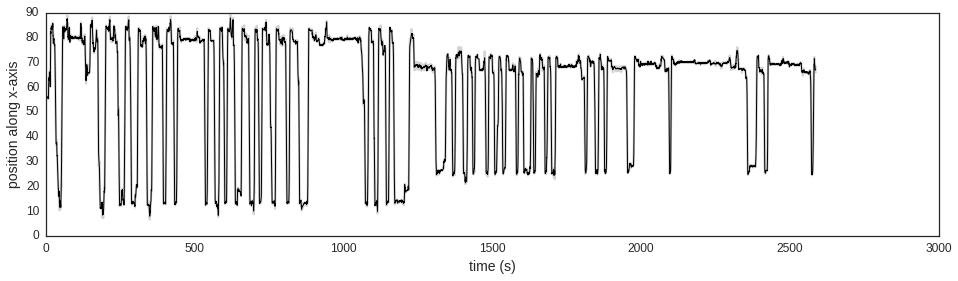

In [2]:
sns.set(rc={'figure.figsize': (16, 4),'lines.linewidth': 1.5, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1 ) = plt.subplots(1,1)

ax1.plot(np.linspace(0,len(df2whl.index)/60,len(df2whl.index)),df2whl['x1'], linewidth=2, color='lightgray' )
ax1.plot(np.linspace(0,len(df2whl.index)/60,len(df2whl.index)),df2whl['x2'], linewidth=2, color='lightgray' )
ax1.plot(np.linspace(0,len(df2whl.index)/60,len(df2whl.index)),(df2whl['x1'] + df2whl['x2'])/2, linewidth=1, color='k' )
#ax1.set_xlim([0,2500])
ax1.set_xlabel('time (s)')
ax1.set_ylabel('position along x-axis')

#saveFigure("figures/x-pos vs time.pdf")


## Load spikes from LinearTwo:

In [3]:
import pickle

#with open('../../Data/st_array1rn.pickle', 'rb') as f:
#    st_array1 = pickle.load(f)
with open('../../Data/st_array2rn.pickle', 'rb') as f:
    st_array2 = pickle.load(f)

## Load Python modules and helper functions

In [4]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import pickle 
import seaborn as sns
#import yahmm as ym

from matplotlib import pyplot as plt
from pandas import Series, DataFrame

from efunctions import * # load my helper functions

%matplotlib inline

from scipy.signal import butter, lfilter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    #y = lfilter(b, a, data)
    y = filtfilt(b, a, data, padlen=150)
    return y

def rms(x):
    return np.sqrt(np.mean(x**2))

def compute_rolling_rms(x,fs,wt=10):
    # fs = sampling frequency
    # wt = sliding window over which to compute rms, in milliseconds
    
    nsamples = len(x)
    
    from collections import deque
    import itertools

    dqfilt = deque(x)
    x_rms = np.zeros(nsamples)
    wn = round(fs/1000*wt)    # number of samples per window to compute RMS power in

    for e in np.arange(nsamples):
        x_rms[e] = rms(np.array(list(itertools.islice(dqfilt, 1, wn+1))))
        dqfilt.rotate(-1)
    
    return x_rms

function saveFigure(filename) loaded

Tip: to save a figure, call saveFigure("path/figure.pdf")


## Build place field map for LinearTwo using only x-coords
1. estimate instantaneous running velocity at 60 Hz
2. smooth running velocity with a zero-phase filter
3. consider only spikes corresponding to bins where the instantaneous velocity is above some threshold (3 cm/s?)
4. determine the number of spikes per position bin, and the duration spent in that bin (all on the suprathreshold data)
5. smooth place fields again? using a Gaussian kernel?

In [5]:
# speed as a function of time...

def get_smooth_speed(x,y,fs=60,th=3,cutoff=0.5,showfig=False):
    dx = np.ediff1d(x,to_begin=0)
    dy = np.ediff1d(y,to_begin=0)
    dvdt = np.sqrt(np.square(dx) + np.square(dy))*60 # cm per second
    t0 = 0
    tend = len(dvdt)/fs # end in seconds

    cutoff=0.5
    dvdtlowpass = np.fmax(0,butter_lowpass_filtfilt(dvdt, cutoff=cutoff, fs=fs, order=6))

    print('The animal (gor01) ran an average of {0:2.2f} cm/s'.format(dvdt.mean()))

    #th = 3 #cm/s
    runindex = np.where(dvdtlowpass>=th); runindex = runindex[0]
    print("The animal ran faster than th = {0:2.1f} cm/s for a total of {1:2.1f} seconds (out of a total of {2:2.1f} seconds).".format(th,len(runindex)/60,len(centerx)/60))
    
    if showfig:
        sns.set(rc={'figure.figsize': (15, 4),'lines.linewidth': 3, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
        sns.set_style("white")

        f, (ax1, ax2) = plt.subplots(1,2)

        ax1.plot(np.arange(0,len(dvdt))/fs,dvdt,alpha=1,color='lightgray',linewidth=2)
        ax1.plot(np.arange(0,len(dvdt))/fs,dvdtlowpass, alpha=1,color='k',linewidth=1)
        ax1.set_xlabel('time (seconds)')
        ax1.set_ylabel('instantaneous velocity (cm/s)')
        ax1.legend(['unfiltered', str(cutoff) + ' Hz lowpass filtfilt'])
        ax1.set_xlim([0,2500])

        ax2.plot(np.arange(0,len(dvdt))/60,dvdt,alpha=1,color='lightgray',linewidth=2)
        ax2.plot(np.arange(0,len(dvdt))/60,dvdtlowpass, alpha=1,color='k',linewidth=1)
        ax2.set_xlabel('time (seconds)')
        ax2.set_ylabel('instantaneous velocity (cm/s)')
        ax2.legend(['unfiltered',  str(cutoff) + ' Hz lowpass filtfilt'])
        ax2.set_xlim([30,70])
  
    return dvdtlowpass, runindex

In [6]:
def list_of_spk_time_arrays_to_spk_counts_arrays(st_array_extern, ds=0, fs=0 ):
    """
    st_array: list of ndarrays containing spike times (in sample numbers!)
    ds:       delta sample number; integer value of samples per time bin
    fs:       sampling frequency
    
    argument logic: if only st_array is passed, use default ds; if ds is passed, use as is and ignore fs; if ds and fs are passed, use ds as time in seconds
    
    returns a (numBins x numCell) array with spike counts
    """
    
    st_array = st_array_extern
    
    if fs == 0:
        if ds == 0:
            ds = 1000 # assume default interval size
    else: # sampling frequency was passed, so interpret ds as time-interval, and convert accordingly:
        if ds == 0:
            ds = 1000 # assume default interval size
        else:
            ds = round(ds*fs)
            
    # determine number of units:
    num_units = len(st_array)
    
    #columns = np.arange(0,num_units)
    #df = DataFrame(columns=columns)
    
    maxtime = 0
    for uu in np.arange(num_units):
        try:
            maxtime = max(st_array[uu].max(), maxtime)
        except:
            maxtime = maxtime
    
    # create list of intervals:
    intlist = np.arange(0,maxtime,ds)
    num_bins = len(intlist)
    
    spks_bin = np.zeros((num_bins,num_units))
    
    print("binning data into {0} x {1:2.1f} ms temporal bins...".format(num_bins, ds*1000/fs))
    
    for uu in np.arange(num_units):
        # count number of spikes in an interval:
        spks_bin[:,uu] = np.histogram(st_array[uu], bins=num_bins, density=False, range=(0,maxtime))[0]
        #spk_count_list.append([x&y for (x,y) in zip(st_array[uu]>ii, st_array[uu] < ii+ds)].count(True))
        #st_array[uu] = st_array[uu][st_array[uu]>ii+ds]        
        #if df.empty:
        #    df = DataFrame([spk_count_list], columns=columns)
        #else:
        #    df = df.append(DataFrame([spk_count_list], columns=columns),ignore_index=True)
                    
    return spks_bin

The animal (gor01) ran an average of 2.89 cm/s
The animal ran faster than th = 3.0 cm/s for a total of 533.6 seconds (out of a total of 2587.8 seconds).
binning data into 155135 x 16.7 ms temporal bins...


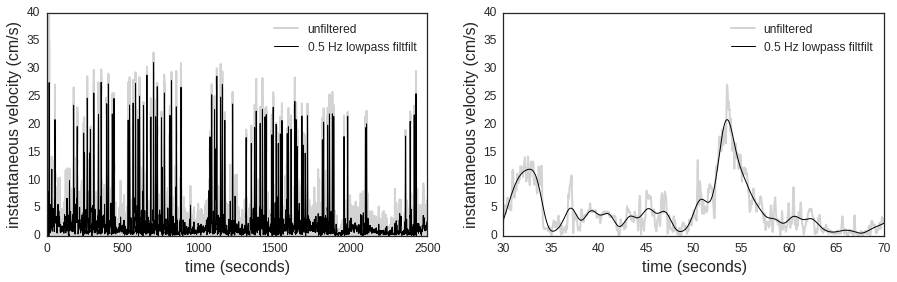

In [7]:
centerx = (np.array(df2whl['x1']) + np.array(df2whl['x2']))/2
centery = (np.array(df2whl['y1']) + np.array(df2whl['y2']))/2

binned_vel_60Hz, binned_runidx_60Hz = get_smooth_speed(centerx,centery,fs=60,th=3,showfig=True)
binned_counts_60Hz = list_of_spk_time_arrays_to_spk_counts_arrays(st_array2, ds=0.016666667, fs=32552)

# trim run indices to same length as spike counts
binned_runidx_60Hz = binned_runidx_60Hz[np.where(binned_runidx_60Hz<len(binned_counts_60Hz))[0]]; # runindexnew = runindexnew[0]

# get bins of spk counts that correspond to where the animal was running above threshold:
binned_counts_60Hz_run = binned_counts_60Hz[binned_runidx_60Hz,:]

In [8]:
def estimate_place_fields(binned_pos,binned_spk_cnts,fs,x0,xl,num_pos_bins=200,minth=0.05,max_meanfiringrate=4,min_maxfiringrate=2):
    
    #num_bins = 200 # position bins for place fields
    #x0 = 0
    #xl = 100

    num_units = len(binned_spk_cnts[0])

    #data = (np.array(df2whl['x1'])[runindex] + np.array(df2whl['x2'])[runindex])/2

    bins = np.linspace(x0,xl,num_pos_bins)
    digitized = np.digitize(binned_pos, bins) # bin numbers
    bin_cnt = [len(binned_pos[digitized == i]) for i in range(1, len(bins))]
    bin_time = [b/fs for b in bin_cnt] # convert to seconds spent in bin

    pfbincenters = bins[:-1] + np.diff(bins)/2

    pf2spk_cnt = np.zeros((num_pos_bins,num_units))
    closest_bins = np.digitize(binned_pos,bins)
    for cnt, bb in enumerate(closest_bins):
        pf2spk_cnt[bb,:] += binned_spk_cnts[cnt,:]
        
    pf2 = []
    pfsmooth = []
#    minth = 0.05 # min threshold for backgrnd spking actvy
    for uu in np.arange(0,num_units):
        pf2.append([b/max(c,1/fs) for (b,c) in zip(pf2spk_cnt[:,uu],bin_time)])
        pfsmooth.append(butter_lowpass_filtfilt(pf2[uu], cutoff=15, fs=200, order=4))

    pfsmooth = np.array(pfsmooth)
    pfsmooth[pfsmooth<minth] = minth # enforce a minimum background firing rate.
    
    # throw away cells that look like interneurons, or cells that are inactive throughout the entire experiment:
    meanfiringrates = pfsmooth.mean(axis=1)
    maxfiringrates = pfsmooth.max(axis=1)

#    max_meanfiringrate = 4 # Hz
#    min_maxfiringrate = 2 # Hz

    pindex = np.where((meanfiringrates<=max_meanfiringrate) & (maxfiringrates>min_maxfiringrate)); pindex = pindex[0]
    print("{0} out of {1} cells passed the criteria to be place cells...".format(len(pindex),len(meanfiringrates)))

    return pfsmooth, pfbincenters, pindex

In [9]:
def show_place_fields(pfs, pfbincenters, pindex):
    
    meanfiringrates = pfs.mean(axis=1)
    maxfiringrates = pfs.max(axis=1)

    # visualize place fields

    # order remaining cells by peak hight along the track
    peaklocations = pfs.argmax(axis=1)
    peakorder = peaklocations[pindex].argsort()

    sns.set(rc={'figure.figsize': (15, 4),'lines.linewidth': 3, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
    sns.set_style("white")

    f, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(2,2)
    ax1.plot(meanfiringrates,linewidth=2,color='lightgray')
    ax1.plot(maxfiringrates,linewidth=1,color='k')
    ax1.legend(['mean firing rate','max firing rate'])
    ax1.set_title('mean and max firing rates of all cells')

    ax2.plot(meanfiringrates[pindex],linewidth=2,color='lightgray')
    ax2.plot(maxfiringrates[pindex],linewidth=1,color='k')
    ax2.legend(['mean firing rate','max firing rate'])
    ax2.set_title('mean and max firing rates of place cells')

    cell_list = pindex

    for uu in cell_list:
        ax3.plot(pfbincenters, pfs[uu], linewidth=1, color='k')

    plt.subplots_adjust(hspace=0.40)
    #ax3.set_title("place fields in LinearTwo",fontsize=14)
    ax1.set_ylabel("firing rate (Hz)")
    ax2.set_ylabel("firing rate (Hz)")
    ax3.set_ylabel("firing rate (Hz)")
    ax3.set_xlim([0,100])
    ax3.set_title('Place fields of place cells')
    
    sns.set(rc={'figure.figsize': (4,8),'lines.linewidth': 3, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
    sns.set_style("white")

    f, axes = plt.subplots(len(pindex), sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0.100)

    for ii,pp in enumerate(pindex[peakorder]):
        axes[ii].plot(pfbincenters, pfs[pp],linewidth=1,color='k')
        axes[ii].fill_between(pfbincenters, 0, pfs[pp], color='gray')
        axes[ii].set_xticks([])
        axes[ii].set_yticks([])
        axes[ii].spines['top'].set_visible(False)
        axes[ii].spines['right'].set_visible(False)
        axes[ii].spines['bottom'].set_visible(False)
        axes[ii].spines['left'].set_visible(False)
        axes[ii].set_ylabel(pp, fontsize=12)
        axes[ii].set_ylim([0,15])

    axes[-1].set_xticks([10,50,90])
    axes[-1].set_xlabel('position along track [cm]')
    f.suptitle('Place fields ordered by peak location along track, cells are zero-indexed.')

24 out of 90 cells passed the criteria to be place cells...


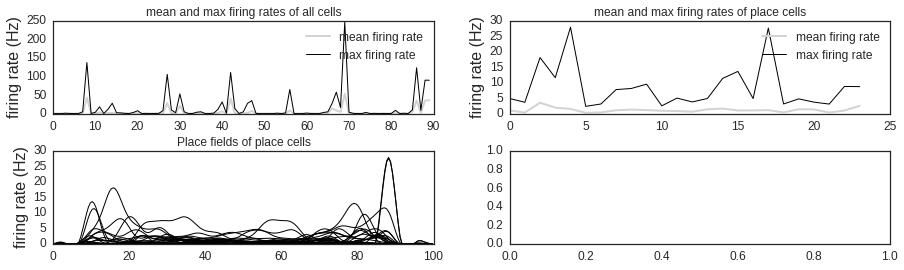

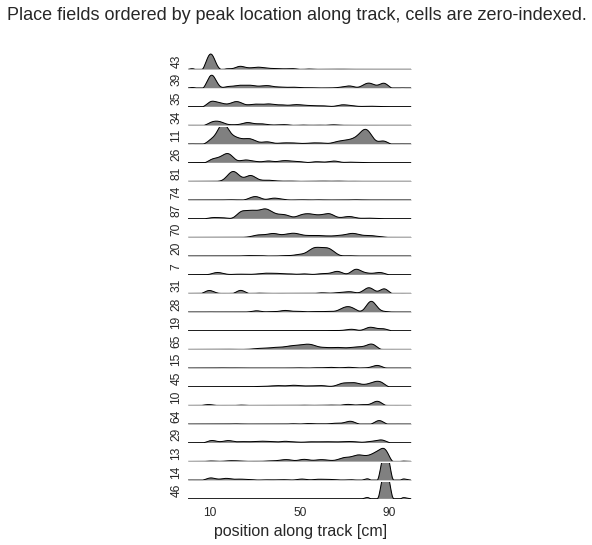

In [10]:
binned_runposx_60Hz = centerx[binned_runidx_60Hz]

pfs, pfbincenters, pindex = estimate_place_fields(binned_runposx_60Hz,binned_counts_60Hz_run,fs=60, x0=0,xl=100,max_meanfiringrate = 4,min_maxfiringrate=2)

show_place_fields(pfs,pfbincenters,pindex)

## Now decode position to see how well we can do
1. using BVR sequences, which is 'cheating', because we used those sequences to learn the place fields
2. using SWR sequences, which is cool, but for which we don't know the ground truth...

### NOTE: we will re-bin observations in 5 ms bins, so that we can do the 20 ms decoding in 5 ms increments
### NOTE: "[SfN] 4 - Place cell overlap" is kind of messy, but finally included the rest-removed BVR creation. I might do a complete overhaul of that though...

"Place fields. Position was linearized and binned into 2.5 cm bins. Directional
place fields were calculated as the number of spikes fired in a particular position
bin and running direction divided by the time spent in that bin, smoothed with a
Gaussian kernel with a s.d. of 5 cm, and identified when the peak firing rate of the
pyramidal cell along the position bins was no less than 1 Hz. The place field size
was defined as the total area of position bins where the firing rates were no less
than 1 Hz." -- Silva, D., Feng, T., & Foster, D. J. (2015). Trajectory events across hippocampal place cells require previous experience. Nature neuroscience, 18(12), 1772-1779.

Here we assume all positions are equally likely, and we use

$$P(\mathbf{x}|\mathbf{n}) = c(\tau,\mathbf{n}) P(\mathbf{x}) \left( \prod_{i=1}^C f_i(\mathbf{x})^{n_i} \right) \exp \left(-\tau \sum_{i=1}^C f_i(\mathbf{x}) \right) $$

to find the distribution at each time point. In particular, we take $\tau=20$ ms, and we advance our decoding window in 5 ms steps.

In [11]:
# note that here we re-sample placefields simply with linear interpolation. A more 'accurate' approach might be to compute the mean firing rate within each new bin...
def resample_placefields(pfsmooth, s_bin, pfbincenters, x0,xl):
    newx = np.arange(x0,xl,s_bin) + s_bin/2
    ss_pfsmooth = np.zeros((pfsmooth.shape[0],len(newx)))
    for cc in np.arange(0,pfsmooth.shape[0]):
        ss_pfsmooth[cc,:] = np.interp(newx,pfbincenters,pfsmooth[cc,:])
    return ss_pfsmooth, newx

def resample_velocity(velocity, t_bin, tvel, t0,tend):
    newt = np.arange(t0,tend,t_bin) + t_bin/2
    newvel = np.zeros((1,len(newt)))
    newvel = np.interp(newt,tvel,velocity)
    return newvel, newt

In [12]:
# need to be able to get place fields in arbitrary [spatial] resolution
# need to be able to get spikes in arbitrary [temporal] resolution
# need to be able to get running velocity in arbitrary [temporal] resolution

x0=0
xl=100

s_bin = 0.5 # cm of spatial bins
ss_pfsmooth, ss_pfbincenters = resample_placefields(pfs, s_bin, pfbincenters, x0, xl)#super-sampled or sub-sampled smoothed place fields

t_bin = 0.25 # sec; temporal resolution for binning spikes
ss_spk_counts2 = list_of_spk_time_arrays_to_spk_counts_arrays(st_array2, ds=t_bin, fs=32552)

# WARNING!! This hack only works for evaluating first half/portion of the data, because the position, velocity, etc. are not automatically changed...
#ss_spk_counts2 = ss_spk_counts2[:round(len(ss_spk_counts2)/2)] # 1st half of data
#ss_spk_counts2 = ss_spk_counts2[round(len(ss_spk_counts2)/2):] # 2nd half of data

tend = len(binned_vel_60Hz)/60 # end in seconds
time_axis = np.arange(0,len(binned_vel_60Hz))/60
ss_velocity, ss_tvel = resample_velocity(velocity=binned_vel_60Hz,t_bin=t_bin,tvel=time_axis,t0=0,tend=tend)
ss_truepos = np.interp(np.arange(0,len(ss_spk_counts2))*t_bin,time_axis,centerx)

print('The animal (gor01) ran an average of {0:2.2f} cm/s'.format(ss_velocity.mean()))

th = 3 #cm/s
ss_runindex = np.where(ss_velocity>=th); ss_runindex = ss_runindex[0]
ss_runindex = ss_runindex[np.where(ss_runindex<len(ss_spk_counts2))[0]]; # runindexnew = runindexnew[0]
print("The animal ran faster than th = {0:2.1f} cm/s for a total of {1:2.1f} seconds (out of a total of {2:2.1f} seconds).".format(th,len(ss_runindex)*t_bin,len(centerx)/60))

tau = 1   # sec (decoding time window)
bins_per_window = round(tau/t_bin)

print("Decoding with {0} x {1} ms bins per window, into one of {2} spatial bins with size {3} cm each...".format(bins_per_window,t_bin*1000,len(ss_pfbincenters),s_bin))

binning data into 10352 x 250.0 ms temporal bins...
The animal (gor01) ran an average of 2.90 cm/s
The animal ran faster than th = 3.0 cm/s for a total of 532.8 seconds (out of a total of 2587.8 seconds).
Decoding with 4 x 250.0 ms bins per window, into one of 200 spatial bins with size 0.5 cm each...


In [ ]:
# problem with approach!!! Discontinuities exist in run segments, so that smoothing can average temporally discontinuous segments!

# solution: first get code working on ALL data (not just run data). However, SWR events can still throw off estimates...

ss_spk_counts2_run = ss_spk_counts2[ss_runindex]
ss_truepos_run = ss_truepos[ss_runindex]

x = ss_pfbincenters # spatial bins **could resample smoothed place fields onto new spatial grid as well, if we want to make it more flexible

#n  C x 1        changes every time step
#fi C x 1        never changes
#f  C x nbins    never changes

trange=1
P = np.zeros((len(ss_pfbincenters),trange))
dec_errors = []
f = ss_pfsmooth[pindex,:]
dec_pos = np.zeros((len(ss_runindex),1))
for tt in np.arange(0,len(ss_runindex)-bins_per_window): #len(spk_counts2_5ms_run)-4):
    #tt+=1 # time index
    n = ss_spk_counts2_run[tt:tt+bins_per_window,pindex].sum(axis=0)

    nn = np.tile(n,(len(ss_pfbincenters),1)).T
    if nn.max() == 0:
        #print('No spikes in window, so cannot decode position!')
        P = P
    else:
        P = np.exp((np.log((f)**(nn))).sum(axis=0) - tau*f.sum(axis=0))
        P = P/P.sum() # normalization not strictly necessary
        est_pos = P.argmax()

        #print("estimated position: {0:2.1f} cm; actual position: {1:2.1f} cm".format(bins[est_pos],truepos_5ms_run[tt]))
        #print("decoding error: {0:2.1f} cm". format(np.abs(bins[est_pos] -truepos_5ms_run[tt])))
        dec_errors.append(np.abs(x[est_pos] -ss_truepos_run[tt+round(bins_per_window/2)]))
        #dec_errors.append(np.abs(x[est_pos] -ss_truepos_run[tt+0]))
        
    dec_pos[tt] = x[P.argmax()]
    
print("average decoding error: {0:2.1f} cm".format(np.array(dec_errors).mean()))

In [ ]:
plt.plot(dec_pos[0:500],linewidth=1,color='lightgray',marker='o')
plt.plot(ss_truepos_run[round(bins_per_window/2):500+round(bins_per_window/2)],linewidth=1,color='k')

In [ ]:
plt.plot(dec_pos[0:500],linewidth=1,color='lightgray',marker='o')
plt.plot(ss_truepos_run[round(bins_per_window/2):500+round(bins_per_window/2)],linewidth=1,color='k')

In [ ]:
plt.plot(dec_pos[:1000],linewidth=1,color='lightgray',marker='o')
plt.plot(ss_truepos_run[round(bins_per_window/2):1000-round(bins_per_window/2)],linewidth=1,color='k')

In [ ]:
plt.plot(dec_pos[:1000],linewidth=1,color='lightgray',marker='o')
plt.plot(ss_truepos_run[round(bins_per_window/2):1000-round(bins_per_window/2)],linewidth=1,color='k')

In [ ]:
plt.plot(dec_pos[-500:],linewidth=1,color='lightgray',marker='o')
plt.plot(ss_truepos_run[-500-0*round(bins_per_window/2):],linewidth=1,color='k')

In [ ]:
plt.plot(dec_pos[-500:],linewidth=1,color='lightgray',marker='o')
plt.plot(ss_truepos_run[-500-0*round(bins_per_window/2):],linewidth=1,color='k')

In [ ]:
plt.plot(dec_pos[-500:],linewidth=1,color='lightgray',marker='o')
plt.plot(ss_truepos_run[-500-0*round(bins_per_window/2):],linewidth=1,color='k')

## Conclusion: second half of [position] data seems messed up... For all the days!

Nevertheless, I will now try to run the correlation analysis on SWR sequences to compare with our replay score

In [ ]:
# step 1. identify SWR sequences: in time bins, or in sampling time? Probably sampling time, followed by binning...
# only keep sequences that meet criteria, namely length 100--500 ms
# step 2. decode w normalized rate tuning curves using the 5-20 ms sliding window approach... 
# Q. What to do about detection on the edges? I can decode T/5-3 positions in a sequence of length T ms
# this is equivalent to 17--97 position estimates for 100--500 ms sequences

## Generate synthetic spikes from learned place fields and actual position data

In [ ]:
def generate_spikes_from_traj(binned_runidx,truepos,pfs,pfbincenters,pos_fs):
   
    from GenerateInhomogeneousPlaceCellSpikes import GenerateSpikes

    # extract running trajectories from real data:
    run_ends = np.where(np.diff(binned_runidx)-1)[0] + 1
    seq_lengths = np.diff(np.hstack((0, run_ends, binned_runidx.size)))
    runbdries = np.hstack((0,run_ends))

    # each spike train corresponding to a trajectory is generated between [0,tend)
    # and then a time offset is added, so that the overall spike times are consistent
    # with that of the original experiment. In that way, when we re-bin and
    # select those bins with run_vel > th, we will get the correct spikes.

    #seq_lengths[sseq_lengths<bins_per_window]

    fs=32552
    numCells = pfs.shape[0]
    NumTrajectories = len(runbdries)
    SpikeRasters = [[[] for _ in range(numCells)] for _ in range(NumTrajectories)] 

    for ii in np.arange(len(runbdries)-1):
        for nn in np.arange(numCells):
            traj_start_bin = binned_runidx[runbdries[ii]]
            traj_end_bin = binned_runidx[runbdries[ii+1]-1] # inclusive
            #print("Trajectory {0} length is {1} bins, or {2:2.2f} seconds.".format(ii,traj_end_bin-traj_start_bin + 1, (traj_end_bin-traj_start_bin + 1)/pos_fs))
            t_offset = traj_start_bin/pos_fs # in seconds
            posvect = truepos[runbdries[ii]:runbdries[ii+1]]
            TrajDuration = len(posvect)/pos_fs
            #print("Traj duration {0:2.2f}".format(TrajDuration))
            tvect = np.linspace(0,TrajDuration, len(posvect)) # WARNING! This does not work when traj_len == 1, but this should never happen anyway

            posFun = lambda t: np.interp(t,tvect,posvect)
            PlaceFieldRate = lambda x: np.interp(x,pfbincenters,pfs[nn,:])
            maxrate = pfs[nn,:].max()

            SpikeRasters[ii][nn] = np.round((t_offset + GenerateSpikes(lambda x,t : PlaceFieldRate(x), maxrate, posFun, TrajDuration))*fs);

    # consolidate spike rasters (not stratified by trajectory)
    cons_st_array = []
    for nn in np.arange(numCells):
        st = np.zeros(0)
        for ii in np.arange(NumTrajectories):
            st = np.hstack((st,SpikeRasters[ii][nn]))
        st = np.sort(st)
        cons_st_array.append(st)
        
    return cons_st_array

In [ ]:
#spk_counts2 = list_of_spk_time_arrays_to_spk_counts_arrays(st_array2, ds=0.016666667, fs=32552)
st_array_synth_run = generate_spikes_from_traj(binned_runidx_60Hz,binned_runposx_60Hz,pfs,pfbincenters,pos_fs=60)
binned_counts_60Hz_run_synth = list_of_spk_time_arrays_to_spk_counts_arrays(st_array_synth_run, ds=0.016666667, fs=32552)

### trim run indices to same length as spike counts
##binned_runidx_60Hz_synth = binned_runidx_60Hz_synth[np.where(binned_runidx_60Hz_synth<len(binned_counts_60Hz_run_synth))[0]]; # runindexnew = runindexnew[0]

pfs_synth, pfbincenters_synth, pindex_synth = estimate_place_fields(binned_runposx_60Hz,binned_counts_60Hz_run_synth,fs=60, x0=0,xl=100,max_meanfiringrate = 4,min_maxfiringrate=2)
show_place_fields(pfs_synth,pfbincenters_synth,pindex_synth)

## Load eeg data for SWR detection

In [14]:
num_channels = 96
#dt = np.dtype([('a', 'i2', (num_channels,))])
dtype = np.dtype([(('ch' + str(ii)), 'i2')  for ii in range(num_channels) ])

# read eeg data:
try:
    eegdata = np.fromfile('C://Etienne//Dropbox//neoReader//Data//gor01-6-7//2006-6-7_16-40-19_lin2//2006-6-7_16-40-19.eeg', dtype=dtype, count=-1)
except:
    print( "Cannot load files in C:/...; trying Unix location instead.")
    try:
        eegdata = np.fromfile('/home/etienne/Dropbox/neoReader/Data/gor01-6-7/2006-6-7_16-40-19_lin2/2006-6-7_16-40-19.eeg', dtype=dtype, count=-1)
    except:
        print( "Cannot load files in Unix location; trying Mac location instead.")
        try:    
            eegdata = np.fromfile('/Users/etienne/Dropbox/neoReader/Data/gor01-6-7/2006-6-7_16-40-19_lin2/2006-6-7_16-40-19.eeg', dtype=dtype, count=-1)
        except:
            print( "Unexpected error:", sys.exc_info()[0] )
            raise
        else:
            print( "Data loaded successfully." )
    else:
        print( "Data loaded successfully." )
else:
    print( "Data loaded successfully." )
    

Cannot load files in C:/...; trying Unix location instead.
Data loaded successfully.


## Create dataframes containing EEG data, with one column for each of the 96 channels
As above, the code below can be improved by wrapping it in a function, and automatically extracting the starting time from the filename, etc.

In [15]:
fs = 1252 # eeg sampling frequency [Hz]

num_records = len(eegdata)
reltime = np.arange(num_records) / fs
#times = map(lambda x:dt.timedelta(seconds=x), reltime)
starttime = pd.to_datetime('200667164019', format='%Y%m%d%H%M%S')
times = map(lambda x:starttime + pd.tseries.timedeltas.to_timedelta(x, unit='s') , reltime)
# transform from record array to ndarray:
data_arr = eegdata.astype(dtype).view('i2')
# reshape data into dataframe size:
data_arr = data_arr.reshape(num_records,num_channels)
# delete 'data', as memory can be an issue here...
del eegdata
# create DataFrame from ndarray:
df = pd.DataFrame(data_arr, index=times, columns=dtype.names) # contains raw eeg data for all channels


In [16]:
df.head()

,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,...,ch86,ch87,ch88,ch89,ch90,ch91,ch92,ch93,ch94,ch95
2006-06-07 16:40:19.000000,-1399,-1267,-1064,-1215,-1234,-1599,-1659,-1559,-1170,-1167,...,968,1287,480,51,110,-284,246,379,493,810
2006-06-07 16:40:19.000799,-1427,-1277,-1130,-1293,-1324,-1659,-1741,-1628,-1203,-1337,...,1018,1317,544,184,204,-156,315,514,676,1102
2006-06-07 16:40:19.001597,-1427,-1367,-1226,-1330,-1368,-1737,-1779,-1645,-1310,-1341,...,925,1277,686,371,321,0,480,619,828,1210
2006-06-07 16:40:19.002396,-1527,-1401,-1207,-1364,-1487,-1789,-1745,-1637,-1295,-1363,...,770,1109,624,281,215,-131,223,297,195,649
2006-06-07 16:40:19.003195,-1523,-1436,-1288,-1413,-1467,-1816,-1740,-1680,-1289,-1312,...,1048,1391,692,316,231,-110,321,301,420,867


NOTE: above functions take quite a while (2 minutes?) to complete... Consider re-writing without Pandas and timestamps for improved speed...

## Filter EEG data for frequency range that is of relevance for SWR detection

### NOTE: we use only one channel to look for SWRs
Currently the choice of which channel to use is somewhat arbitrary...

In [17]:
# choose EEG channel to use to look for SWR events:
ch = 'ch1'

# extract single EEG channel
x_unfilt = df[ch].values
x_unfilt = x_unfilt.astype(int) # convert from int16 to int to prevent overflow when calling e.g. rms(); we don't actually use it like that though...

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1252.0
lowcut = 150.0
highcut = 250.0

# filter selected channel:
x_filt = butter_bandpass_filter(x_unfilt, lowcut, highcut, fs, order=6)

#nsamples = len(x_unfilt)
#T = nsamples/fs
#t = np.linspace(0, T, nsamples, endpoint=False)

filt_rms_5ms = compute_rolling_rms(x_filt,fs,wt=5)
filt_rms_10ms = compute_rolling_rms(x_filt,fs,wt=10)

# compute mean and sd of rms signal:    
filt_rms_mu_5ms = filt_rms_5ms.mean()
filt_rms_sd_5ms = filt_rms_5ms.std()
filt_rms_mu_10ms = filt_rms_10ms.mean()
filt_rms_sd_10ms = filt_rms_10ms.std()


### Here I can play around with how much the rms power must exceed the background level to be considered an SWR event:

In [18]:
# identify windows where RMS power exceeds 5 (=alpha) times the SD of the RMS power:
alpha = 5

selector_5ms = (alpha*filt_rms_sd_5ms + filt_rms_mu_5ms <= filt_rms_5ms)
selector_10ms = (alpha*filt_rms_sd_10ms + filt_rms_mu_10ms <= filt_rms_10ms)

wn_alpha_sd_idx_5ms = list(np.where(selector_5ms))[0] # indices ito eeg sample numbers (fs=1252 Hz) of which samples exceeded threshold
wn_alpha_sd_idx_10ms = list(np.where(selector_10ms))[0] # indices ito eeg sample numbers (fs=1252 Hz) of which samples exceeded threshold


## Create dataframe with SWR events as detected above

Here we take all the windows in the EEG that satisfied the criteria of increased rms power, and we create a dataframe with the start, end, and duration of each such event.

**TO-DO:** Additionally, we may want to screen events further, to drop those that are either too short, or too long, or undesirable in some other way.

In [19]:
# this is a little helper function that can be used similar to MATLAB's find(), except that it returns all the
# indices, and cannot be stopped after finding just the first, for example.
# usage example: idx = indices(input_array, lambda x: x > pos)[0]

def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

In [20]:
def build_swr_event_dataframe(wn_alpha_sd_idx,filt_rms,fs):
    
    #n_samples is simply the maximum position that events can go to, and can be set to maxpos = len(filt_rms)
    
    swr_start = []
    swr_end = []

    nomoreevents = False
    
    filtsd = filt_rms.std()
    maxpos = len(filt_rms)
    
    # find first SWR start event by backtracking from first event:
    pos = wn_alpha_sd_idx[0]

    while not nomoreevents:
        found_start = False
        while not found_start:
            pos -= 1
            if pos == 0:
                found_start = True
                swr_start.append(pos + 1)
            if filt_rms[pos] < filtsd:
                found_start = True
                swr_start.append(pos + 1)
        # now find where the SWR event ends:
        found_end = False
        while not found_end:
            pos += 1
            if pos == maxpos:
                found_end = True
                swr_end.append(maxpos)
            if filt_rms[pos] < filtsd:
                found_end = True
                swr_end.append(pos - 1)      
        # find next SWR event AFTER previous end
        try:
            newwn = indices(wn_alpha_sd_idx, lambda x: x > pos)[0]
            pos = wn_alpha_sd_idx[newwn]
        except:
            nomoreevents = True

    # build DataFrame with start, stop, and duration for SWR events:
    SWR_events = pd.DataFrame({'start': swr_start, 'end': swr_end}, columns=["start", "end"]) 
    SWR_events["duration_ms"] = (SWR_events.end.values - SWR_events.start.values)/fs*1000
    
    return SWR_events

In [21]:
SWR_events_5ms = build_swr_event_dataframe(wn_alpha_sd_idx_5ms,filt_rms_5ms,fs)
SWR_events_10ms = build_swr_event_dataframe(wn_alpha_sd_idx_10ms,filt_rms_10ms,fs)
# note: SWR_events have start and end times ito sample numbers (where fs = 1252 Hz)
print('when computing rolling RMS in a 5 ms window:')
print(SWR_events_5ms[0:10])
print('')
print('when computing rolling RMS in a 10 ms window:')
print(SWR_events_10ms[0:10])

when computing rolling RMS in a 5 ms window:
   start    end  duration_ms
0  11164  11718   442.492013
1  11721  11819    78.274760
2  20480  20559    63.099042
3  20684  20826   113.418530
4  20831  20874    34.345048
5  21159  21223    51.118211
6  39758  39815    45.527157
7  63616  63684    54.313099
8  68250  68303    42.332268
9  78058  78115    45.527157

when computing rolling RMS in a 10 ms window:
    start     end  duration_ms
0   10967   12134   932.108626
1   20677   20927   199.680511
2   39570   39815   195.686901
3   63609   63763   123.003195
4   68183   68386   162.140575
5   83385   83598   170.127796
6   84119   84224    83.865815
7  110385  110515   103.833866
8  110747  110934   149.361022
9  112782  112875    74.281150


In [22]:
SWR_events = SWR_events_5ms 

# restrict minimum and maximum SWR sequence durations...
min_swr_duration = 100 #ms
max_swr_duration = 500 #ms
SWR_events = SWR_events[(SWR_events['duration_ms']>=min_swr_duration) & (SWR_events['duration_ms']<=max_swr_duration)]
SWR_events.reset_index(drop=True, inplace=True)

print('A total of {0} SWR sequences passed the length requirements...'.format(SWR_events.index[-1]))

SWR_events.head()

A total of 185 SWR sequences passed the length requirements...


,start,end,duration_ms
0,11164,11718,442.492013
1,20684,20826,113.418530
2,114208,114364,124.600639
3,186590,186820,183.706070
4,223273,223456,146.166134


In [23]:
# WARNING! 
# SWR_events are in sample #s with fs = 1252, whereas st_array spike times are in sample #s with fs = 32552

fsEEG = 1252
fsSpikes = 32552

st_array_fsEEG = [x*(fsEEG/fsSpikes) for x in st_array2] # spike times in fsEEG sample numbers (not integral)

In [24]:
# extract observation sequences corresponding to SWR events
def extract_and_bin_spikes_during_swr_events(SWR_events, st_arrayfsEEG, bintime = 10):
    # bintime in milliseconds
    from math import ceil
    # given SWR_ch1_events (dataframe) and st_array1fsEEG and st_array2fsEEG, we build the list of lists of lists of arrays:

    #bintime = 10 # bin time in ms, has to be small to work with replay


    N = len(SWR_events.index) # number of SWR events
    num_units = len(st_arrayfsEEG) # number of units
    spk_cnters = np.zeros((num_units,1),dtype=np.int32)

    SWRspikes = []

    for row in SWR_events.itertuples():
        idx, start, stop, duration = zip(row) # still tuples
        idx = idx[0]; start = start[0]; stop = stop[0]; duration = duration[0]
        # determine sequence length in number of bins:
        num_bins = ceil(duration/bintime)
        SWRspikes.append([]) # list for idx=nth SWR event
        for bb in np.arange(0,num_bins):
            SWRspikes[idx].append([]) # add list element for each bin in sequence
            for uu in np.arange(0,num_units):
                # count spikes in bin and advance spike time array counter to make subsequent searches faster:
                spk_cnters[uu][0] = spk_cnters[uu][0] + len(st_arrayfsEEG[uu][spk_cnters[uu][0]:][st_arrayfsEEG[uu][spk_cnters[uu][0]:]<start+(bb)*bintime])
                #debug#print("skip first {0} spikes for unit {1}...".format(spk_cnters[uu][0],uu))
                tempspikes = st_arrayfsEEG[uu][spk_cnters[uu][0]:][st_arrayfsEEG[uu][spk_cnters[uu][0]:]<=start+(bb+1)*bintime]
                numspikes = len(tempspikes)
                #debug#print("spikes in bin {0} of unit {1}: {2}".format(bb,uu,numspikes))
                SWRspikes[idx][bb].append(np.array(numspikes))
                
    return SWRspikes

#SWRspikes = extract_and_bin_spikes_during_swr_events( SWR_events1, st_array_fsEEG1, bintime = 5 )



In [25]:
#binned_counts_5ms = list_of_spk_time_arrays_to_spk_counts_arrays(st_array2, ds=0.005, fs=32552)
binned_counts_5ms_SWR = extract_and_bin_spikes_during_swr_events( SWR_events, st_array_fsEEG, bintime = 5 )

## All the sequences in binned_counts_5ms_SWR are now ready to scale-and-evaluate in a trained BVR HMM, as well as for decoding using the Bayesian decoder, followed by the correlation analysis.

## Correlation analysis (assumes good decoding accuracy)
My current understanding of this correlation analysis is that it is only appropriate for constant velocity linear sequences. Is this intuition correct?

In [26]:
def mXprob(X,prob):
    den = prob.sum()
    num = (prob*X).sum()
    return num/den

def covXYprob(X,Y,prob):
    den = prob.sum()
    num = (prob*(X - mXprob(X,prob))*(Y - mXprob(Y,prob))).sum()
    return num/den

def corrXYprob(X,Y,prob):
    den = np.sqrt(covXYprob(X,X,prob)*covXYprob(Y,Y,prob))
    num = covXYprob(X,Y,prob)
    return num/den

In [27]:
# note that here we re-sample placefields simply with linear interpolation. A more 'accurate' approach might be to compute the mean firing rate within each new bin...
def resample_placefields(pfsmooth, s_bin, pfbincenters, x0,xl):
    newx = np.arange(x0,xl,s_bin) + s_bin/2
    ss_pfsmooth = np.zeros((pfsmooth.shape[0],len(newx)))
    for cc in np.arange(0,pfsmooth.shape[0]):
        ss_pfsmooth[cc,:] = np.interp(newx,pfbincenters,pfsmooth[cc,:])
    return ss_pfsmooth, newx

def resample_velocity(velocity, t_bin, tvel, t0,tend):
    newt = np.arange(t0,tend,t_bin) + t_bin/2
    newvel = np.zeros((1,len(newt)))
    newvel = np.interp(newt,tvel,velocity)
    return newvel, newt

Decoding with 4 x 5.0 ms bins per window, into one of 200 spatial bins with size 0.5 cm each...


nan

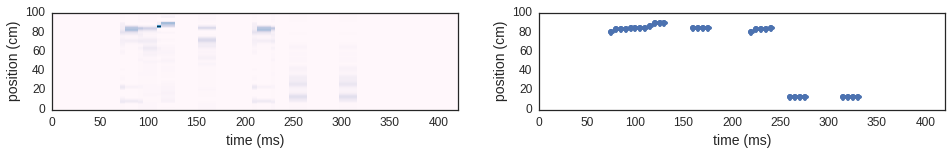

In [31]:
def decode_swr_sequence(seq,pfs,pfbincenters,pindex,t_bin,tau,showfig=False):

    #n  C x 1        changes every time step
    #fi C x 1        never changes
    #f  C x nbins    never changes

    seq = np.array(seq)
    bins_per_window = round(tau/t_bin)
    num_tbins=len(seq)
    PP = np.zeros((len(pfbincenters),num_tbins))
    f = pfs[pindex,:]
    dec_pos = np.zeros((num_tbins-bins_per_window,1))
    prob = np.zeros((num_tbins-bins_per_window,1))
    est_pos_idx = 0
        
    for tt in np.arange(0,num_tbins-bins_per_window): #len(spk_counts2_5ms_run)-4):
        #tt+=1 # time index
        n = seq[tt:tt+bins_per_window,pindex].sum(axis=0)
        nn = np.tile(n,(len(ss_pfbincenters),1)).T
        if nn.max() == 0:
            #print('No spikes in decoding window, so cannot decode position!')
            PP[:,tt] = PP[:,tt]
            est_pos_idx = np.nan
            dec_pos[tt] = np.nan
            prob[tt] = np.nan
        else:
            #print('Some spikes detected in decoding window.. yeah!!!')
            PP[:,tt] = np.exp((np.log((f)**(nn))).sum(axis=0) - tau*f.sum(axis=0))
            PP[:,tt] = PP[:,tt]/PP[:,tt].sum() # normalization not strictly necessary
            est_pos_idx = PP[:,tt].argmax()
            dec_pos[tt] = ss_pfbincenters[est_pos_idx]
            prob[tt] = PP[est_pos_idx,tt]
    T = np.arange(0,num_tbins-bins_per_window)*t_bin*1000
    
    if showfig:
        sns.set(rc={'figure.figsize': (16, 6),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
        sns.set_style("white")
        f, (ax1, ax2) = plt.subplots(1,2)

        x0=0
        xl=np.ceil(pfbincenters[-1]/10)*10
        tend=num_tbins*5
        extent=(0,T[-1],x0,xl)
        ax1.imshow(PP,cmap='PuBu',origin='lower',extent=extent,interpolation='none')
        yticks=np.arange(x0,xl+1,20)
        ax1.set_yticks(yticks)
        ax1.set_ylabel('position (cm)')
        ax1.set_xlabel('time (ms)')
        ax2.plot(T, dec_pos,marker='o')
        ax2.set_aspect('equal')
        ax2.set_ylim([x0,xl])
        ax2.set_xlim([0,T[-1]])
        ax2.set_yticks(yticks)
        ax2.set_ylabel('position (cm)')
        ax2.set_xlabel('time (ms)')
    
    return T, dec_pos, prob, PP


s_bin = 0.5 # cm of spatial bins
ss_pfsmooth, ss_pfbincenters = resample_placefields(pfs, s_bin, pfbincenters, x0=0, xl=100)#super-sampled or sub-sampled smoothed place fields

t_bin = 0.005 # sec; temporal resolution for binning spikes
#ss_spk_counts2 = list_of_spk_time_arrays_to_spk_counts_arrays(st_array2, ds=t_bin, fs=32552)

tau = 0.02   # sec (decoding time window)
#bins_per_window = round(tau/t_bin)

t_bin = 0.005 # sec; temporal resolution for binning spikes
#ss_spk_counts2 = list_of_spk_time_arrays_to_spk_counts_arrays(st_array2, ds=t_bin, fs=32552)

tau = 0.02   # sec (decoding time window)
bins_per_window = round(tau/t_bin)
print("Decoding with {0} x {1} ms bins per window, into one of {2} spatial bins with size {3} cm each...".format(bins_per_window,t_bin*1000,len(ss_pfbincenters),s_bin))
    
# decode SWR trajectory:
seqidx=0
seq = binned_counts_5ms_SWR[seqidx]
T, P, prob, PP = decode_swr_sequence(seq,ss_pfsmooth,ss_pfbincenters,pindex,t_bin=t_bin,tau=tau,showfig=True)
            
corrXYprob(T,P,prob)



In [ ]:
for seq in binned_counts_5ms_SWR:
    #print('decoding SWR sequence of approx {0:2.1f} ms.'.format(len(seq)*5))
    T, P, prob, PP = decode_swr_sequence(seq,ss_pfsmooth,ss_pfbincenters,pindex,t_bin=t_bin,tau=tau,showfig=True)


## Next steps

* Decide what to do with windows where no spikes are observed. Truncate sequences (before and after) and break sequences up?
* Evaluate (possibly modified, see above) sequence in scaled BVR HMM and compute score
* Shuffle sequences in several ways, and compute both correlation and HMM replay sequence scores
* Figure out why place field estimation wrapper introduced some bug
* Verify place field rate scaling
* Figure out why rolling RMS (and hence SWR sequence identification) is so sensitive to the window duration
* change replay score to P(y_t+1|y_t) for unambiguous evaluation
* refactor code further to make it easier to re-run analysis on different data
* re-write LFP filtering routines to make them faster and to get rid of Pandas time objects
